[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioRR-Tec/Machine-Learning/blob/master/Notebooks/Module_2/Ejercicio_Prediccion.ipynb)

## EJERCICIO - EXTRA:

Con el fin de entender **un poquitín** mejor el estado de la pandemia por el COVID19 en México, realizaremos un pronóstico de los **nuevos casos por día**.

Asumiremos que ES POSIBLE predecir el comportamiento de los **nuevos casos por día** a partir del comportamiento de otros paises utilizando una regresión lineal. En este sentido, asumimos que:
1. El número de **nuevos casos por día** es un reflejo de las características de los los diferentes paises como las medidas tomadas respecto al distanciamiento social, distribución socioeconómica, conectividad con otros paises, tiempo del primer caso, condiciones ambientales, etc.
2. Es posible predecir los **nuevos casos por día** utilizando una RLM (al menos a corto plazo).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline

In [2]:
#Html paths for csv files from John Hopkins - Confirmed / Death cases
confirmedPath = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deathsPath = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [4]:
confirmed_cases = pd.read_csv(confirmedPath, header=0, index_col=0, parse_dates=True, squeeze=True)
death_cases = pd.read_csv(deathsPath, header=0, index_col=0, parse_dates=True, squeeze=True)
confirmed_cases = confirmed_cases.reset_index()
death_cases = death_cases.reset_index()

In [5]:
cols = confirmed_cases.keys()
cols

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '8/29/20', '8/30/20', '8/31/20', '9/1/20', '9/2/20', '9/3/20', '9/4/20',
       '9/5/20', '9/6/20', '9/7/20'],
      dtype='object', length=234)

In [6]:
confirmed = confirmed_cases.loc[:, cols[4]:cols[-1]]
deaths = death_cases.loc[:, cols[4]:cols[-1]]

In [7]:
confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20
0,0,0,0,0,0,0,0,0,0,0,...,38143,38162,38165,38196,38243,38288,38304,38324,38398,38494
1,0,0,0,0,0,0,0,0,0,0,...,9279,9380,9513,9606,9728,9844,9967,10102,10255,10406
2,0,0,0,0,0,0,0,0,0,0,...,43781,44146,44494,44833,45158,45469,45773,46071,46364,46653
3,0,0,0,0,0,0,0,0,0,0,...,1124,1124,1176,1184,1199,1199,1215,1215,1215,1261
4,0,0,0,0,0,0,0,0,0,0,...,2551,2624,2654,2729,2777,2805,2876,2935,2965,2981


In [10]:
dates = confirmed.keys()
world_cases = []
total_deaths = []
mortality_rate = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)

In [18]:
days_since = np.array([i for i in range(len(dates))]).reshape(-1,1)
world_cases = np.array(world_cases).reshape(-1,1)
total_deaths = np.array(total_deaths).reshape(-1,1)

In [21]:
days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1)
adjusted_dates = future_forecast[:-10]

In [24]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [25]:
latest_confirmed = confirmed_cases[dates[-1]]
latest_deaths = death_cases[dates[-1]]

In [26]:
unique_countries = list(confirmed_cases['Country/Region'].unique())

In [28]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_cases['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key = operator.itemgetter(1), reverse = 1)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_cases['Country/Region']==unique_countries[i]].sum()

In [29]:
print('Confirmed Cases By Countries:')
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}:{country_confirmed_cases[i]} cases')

Confirmed Cases By Countries:
US:6300622 cases
India:4280422 cases
Brazil:4147794 cases
Russia:1027334 cases
Peru:689977 cases
Colombia:671848 cases
South Africa:639362 cases
Mexico:637509 cases
Spain:525549 cases
Argentina:488007 cases
Chile:424274 cases
Iran:388810 cases
France:367174 cases
United Kingdom:352451 cases
Bangladesh:327359 cases
Saudi Arabia:321456 cases
Pakistan:299233 cases
Turkey:281509 cases
Italy:278784 cases
Iraq:264684 cases
Germany:253626 cases
Philippines:238727 cases
Indonesia:196989 cases
Ukraine:141424 cases
Canada:134295 cases
Israel:133975 cases
Bolivia:121604 cases
Qatar:120348 cases
Ecuador:110092 cases
Kazakhstan:106425 cases
Egypt:100041 cases
Dominican Republic:99898 cases
Panama:97578 cases
Romania:95897 cases
Kuwait:90387 cases
China:90078 cases
Belgium:88769 cases
Oman:87328 cases
Sweden:85558 cases
Netherlands:78702 cases
Guatemala:77828 cases
United Arab Emirates:74454 cases
Morocco:73780 cases
Belarus:73031 cases
Japan:72213 cases
Poland:71126 ca

In [30]:
unique_provinces = list(confirmed_cases['Province/State'].unique())
province_confirmed_cases = []
no_cases = []
for i in unique_provinces:
    cases = latest_confirmed[confirmed_cases['Province/State']==i].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_provinces.remove(i)

In [31]:
for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}: {province_confirmed_cases[i]} cases')

Australian Capital Territory: 113 cases
New South Wales: 4126 cases
Northern Territory: 33 cases
Queensland: 1134 cases
South Australia: 464 cases
Tasmania: 230 cases
Victoria: 19615 cases
Western Australia: 658 cases
Alberta: 14474 cases
British Columbia: 6162 cases
Grand Princess: 13 cases
Manitoba: 1338 cases
New Brunswick: 192 cases
Newfoundland and Labrador: 270 cases
Northwest Territories: 5 cases
Nova Scotia: 1086 cases
Ontario: 45314 cases
Prince Edward Island: 51 cases
Quebec: 63713 cases
Saskatchewan: 1662 cases
Yukon: 15 cases
Anhui: 991 cases
Beijing: 935 cases
Chongqing: 584 cases
Fujian: 387 cases
Gansu: 170 cases
Guangdong: 1769 cases
Guangxi: 257 cases
Guizhou: 147 cases
Hainan: 171 cases
Hebei: 365 cases
Heilongjiang: 948 cases
Henan: 1276 cases
Hong Kong: 4889 cases
Hubei: 68139 cases
Hunan: 1019 cases
Inner Mongolia: 261 cases
Jiangsu: 665 cases
Jiangxi: 935 cases
Jilin: 157 cases
Liaoning: 263 cases
Macau: 46 cases
Ningxia: 75 cases
Qinghai: 18 cases
Shaanxi: 377 ca

In [32]:
nan_indices = []

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)
        
unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

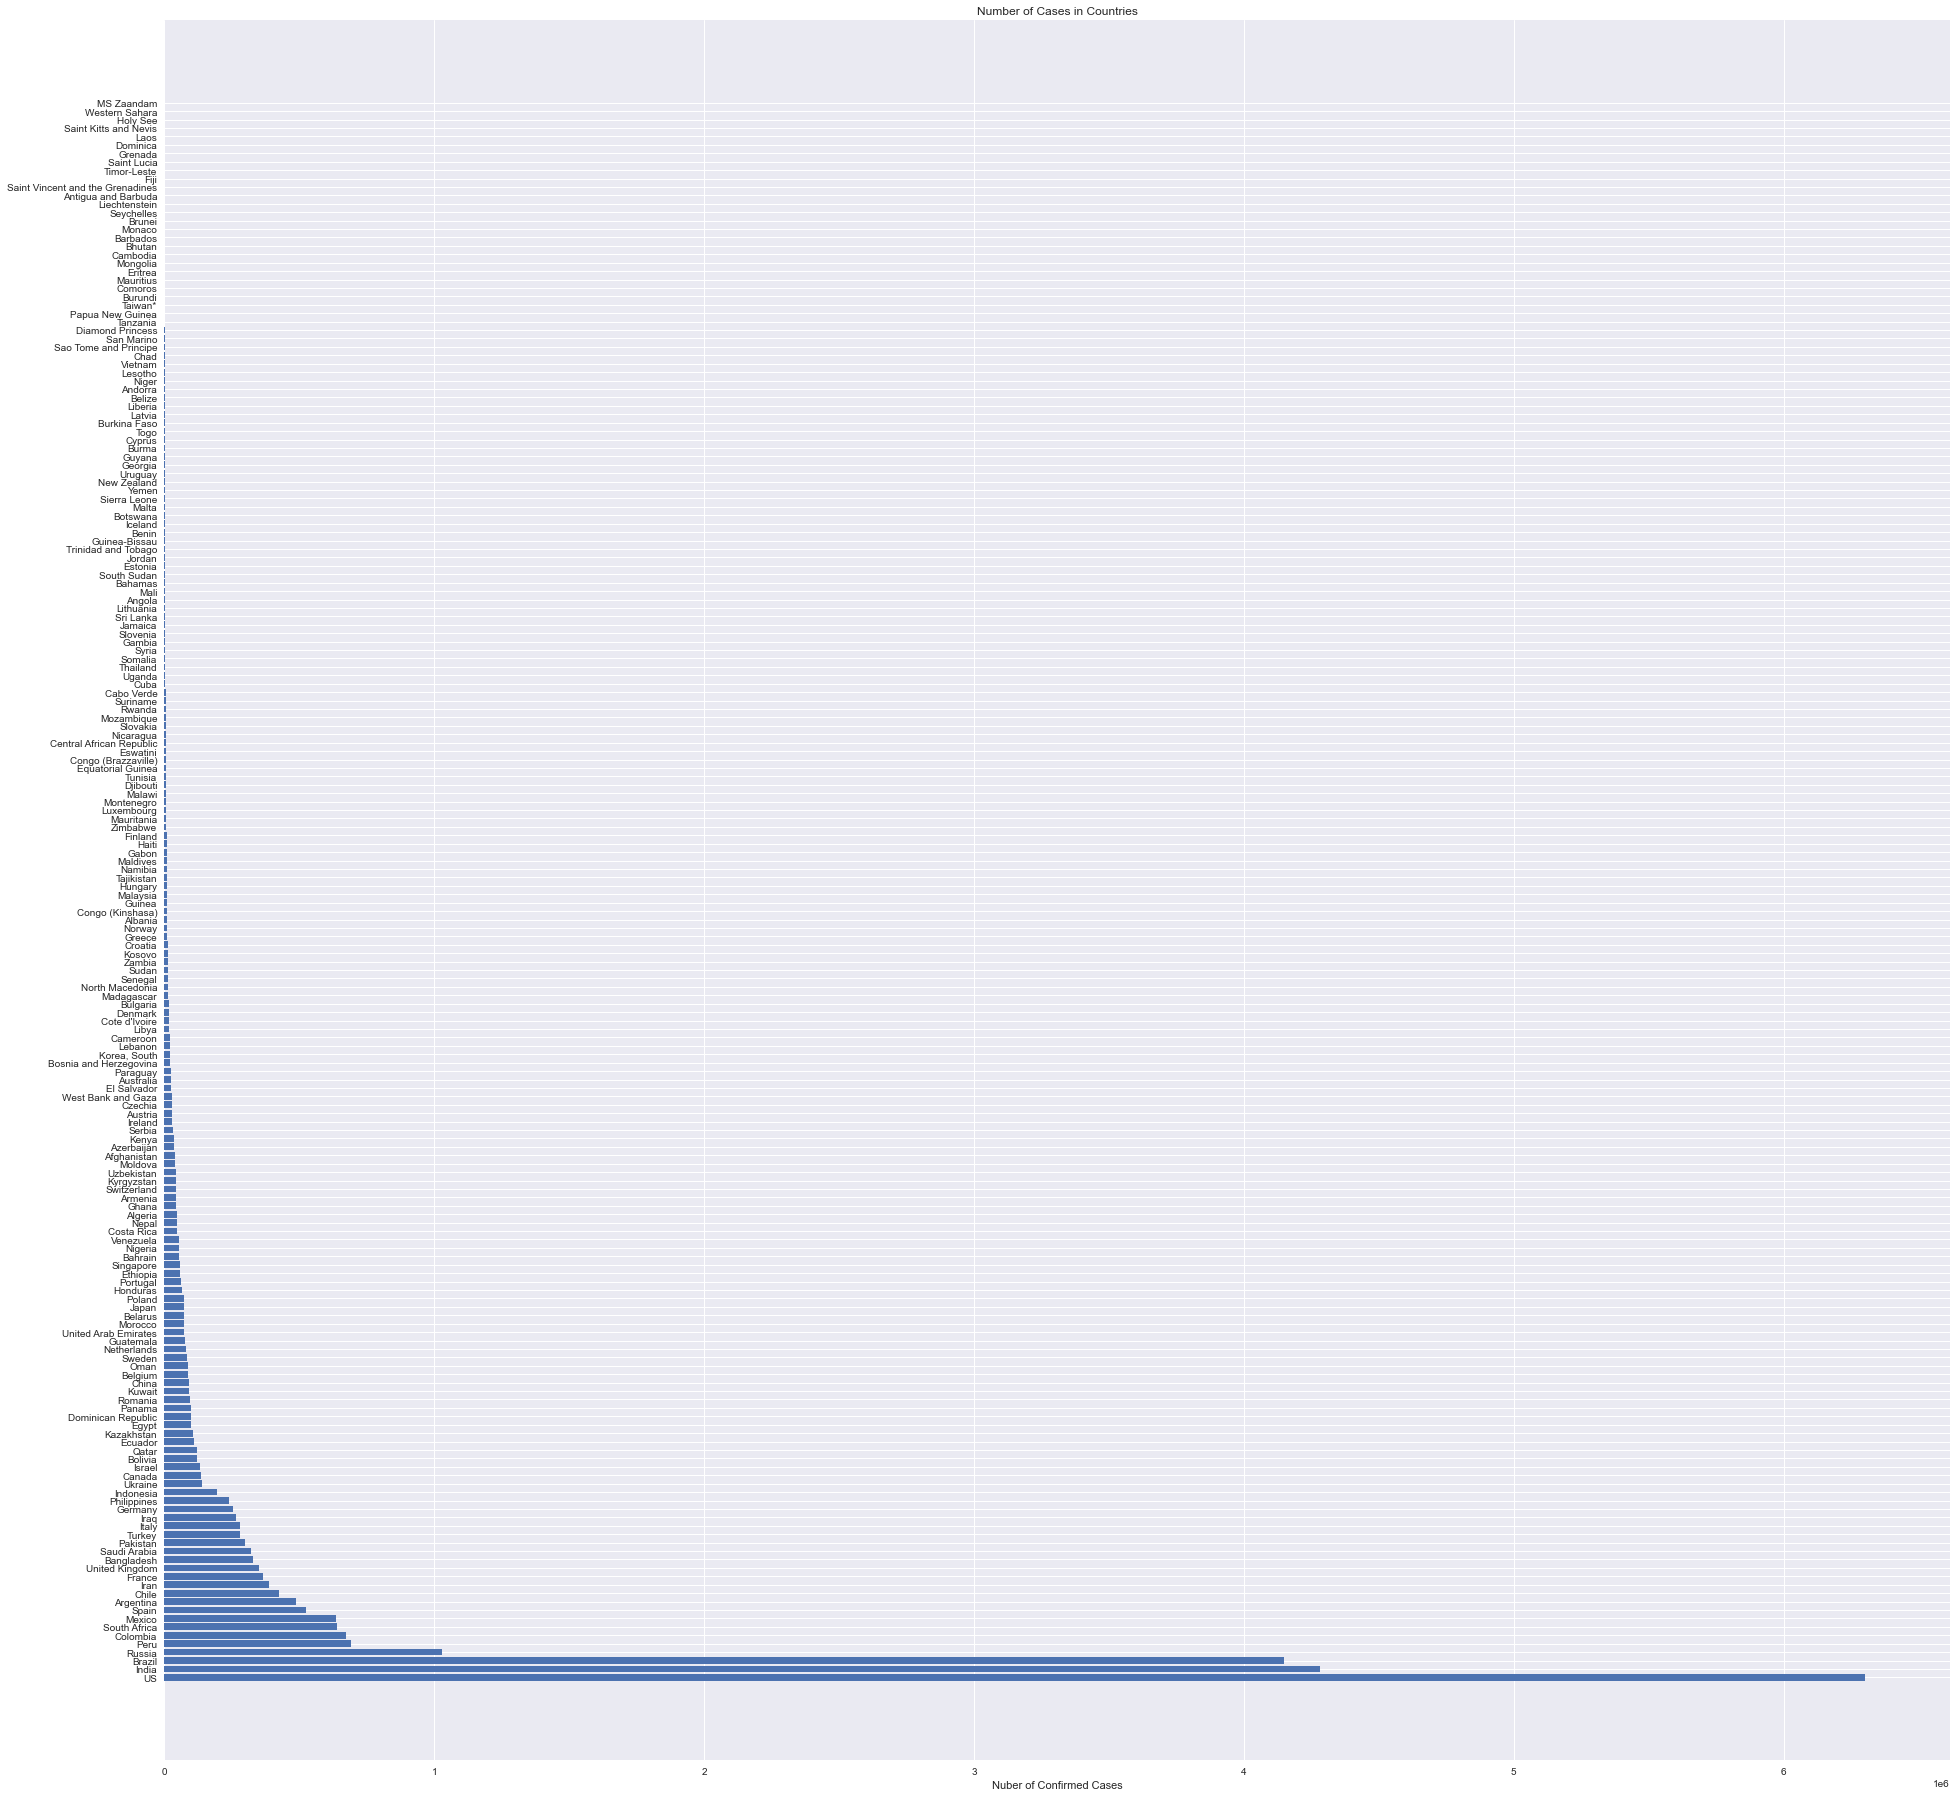

In [33]:
plt.figure(figsize = ((32,32)))
plt.barh(unique_countries, country_confirmed_cases)
plt.title('Number of Cases in Countries')
plt.xlabel('Nuber of Confirmed Cases')
plt.show()

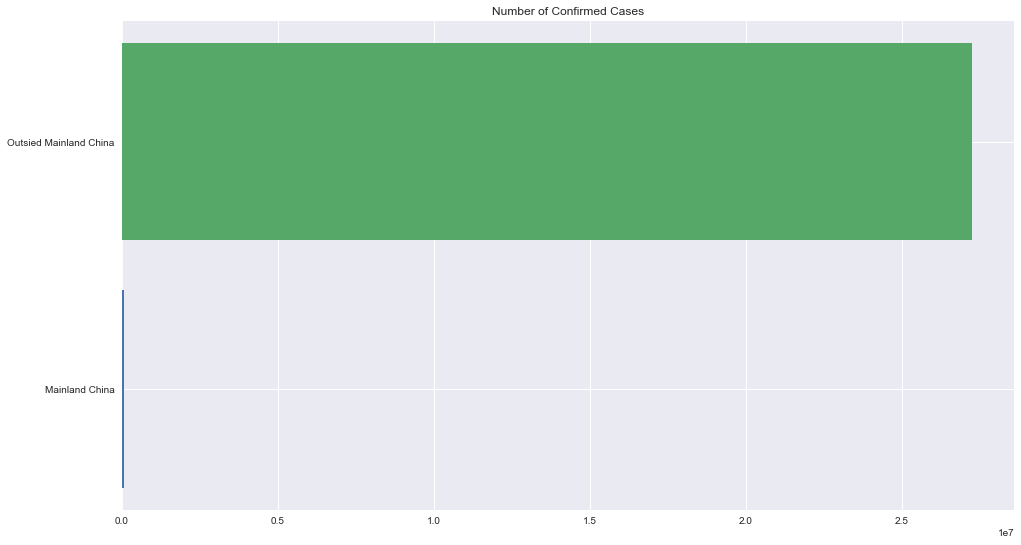

In [34]:
china_confirmed = latest_confirmed[confirmed_cases['Country/Region'] == 'China'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16,9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outsied Mainland China', outside_mainland_china_confirmed)
plt.title('Number of Confirmed Cases')
plt.show()

In [35]:
print('Outsude Mainland China {} cases'.format(outside_mainland_china_confirmed))
print('Mainland China {} cases'.format(china_confirmed))
print('Total {} cases'.format(china_confirmed + outside_mainland_china_confirmed))

Outsude Mainland China 27247682 cases
Mainland China 90078 cases
Total 27337760 cases


In [36]:
visual_unique_countries = []
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

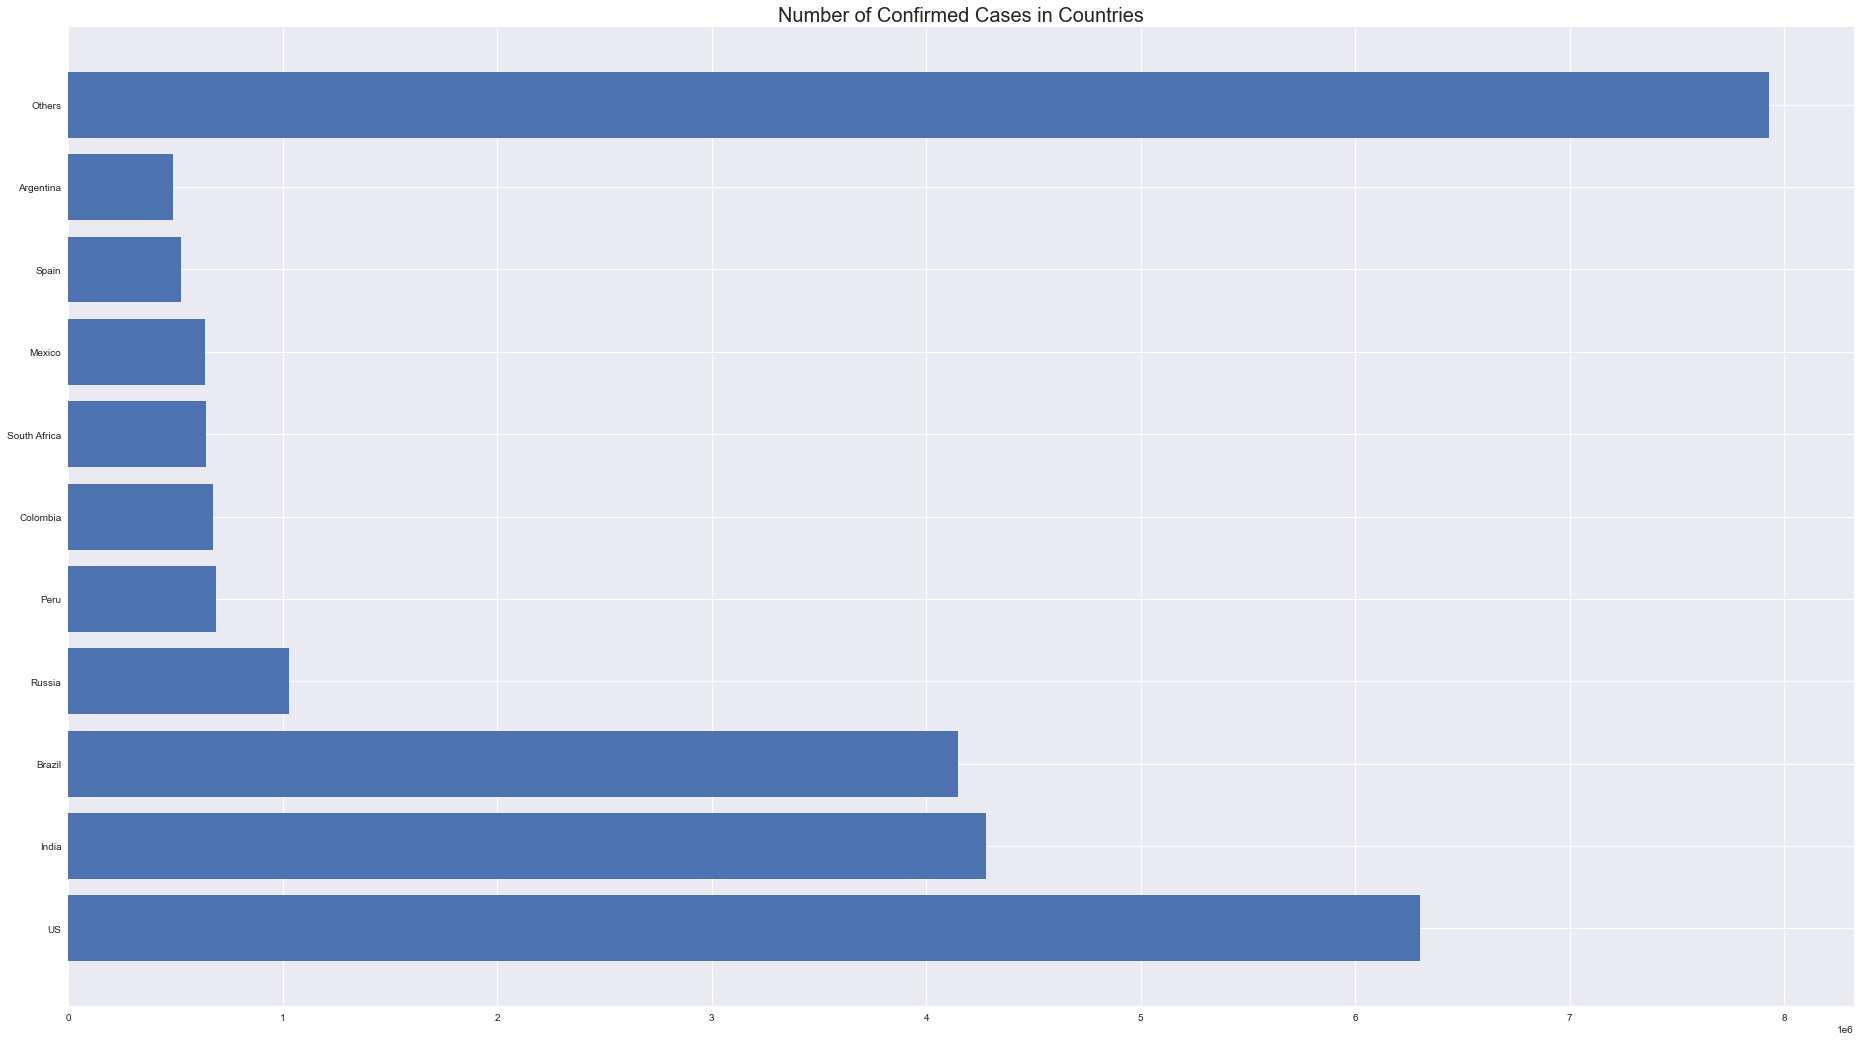

In [37]:
plt.figure(figsize=(32,18))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('Number of Confirmed Cases in Countries', size = 20)
plt.show()

!pip install --user matplotlib --upgrade


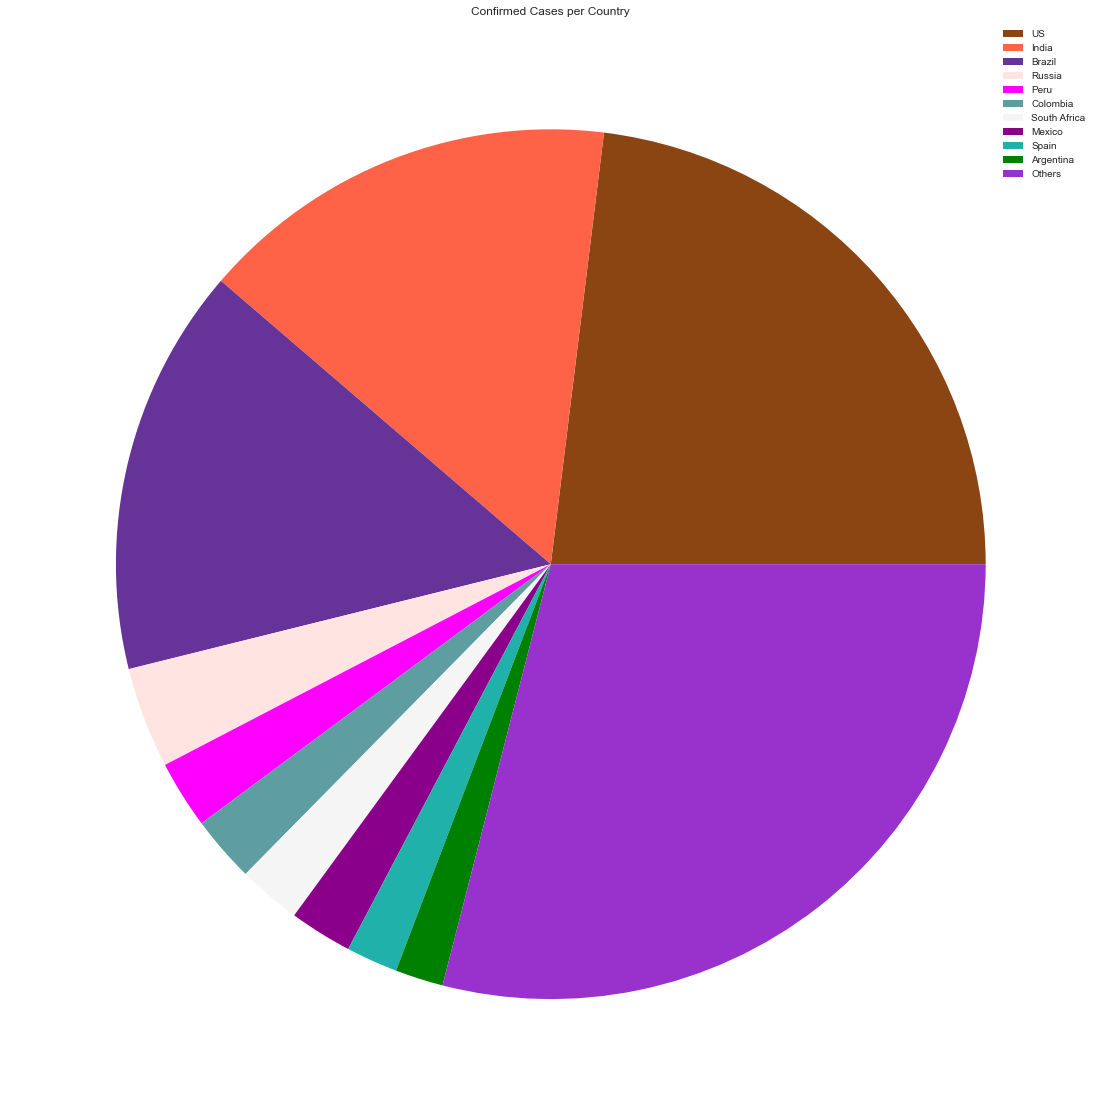

In [38]:
c = random.choices(list(mcolors.CSS4_COLORS.values()), k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Confirmed Cases per Country')
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best')
plt.show()

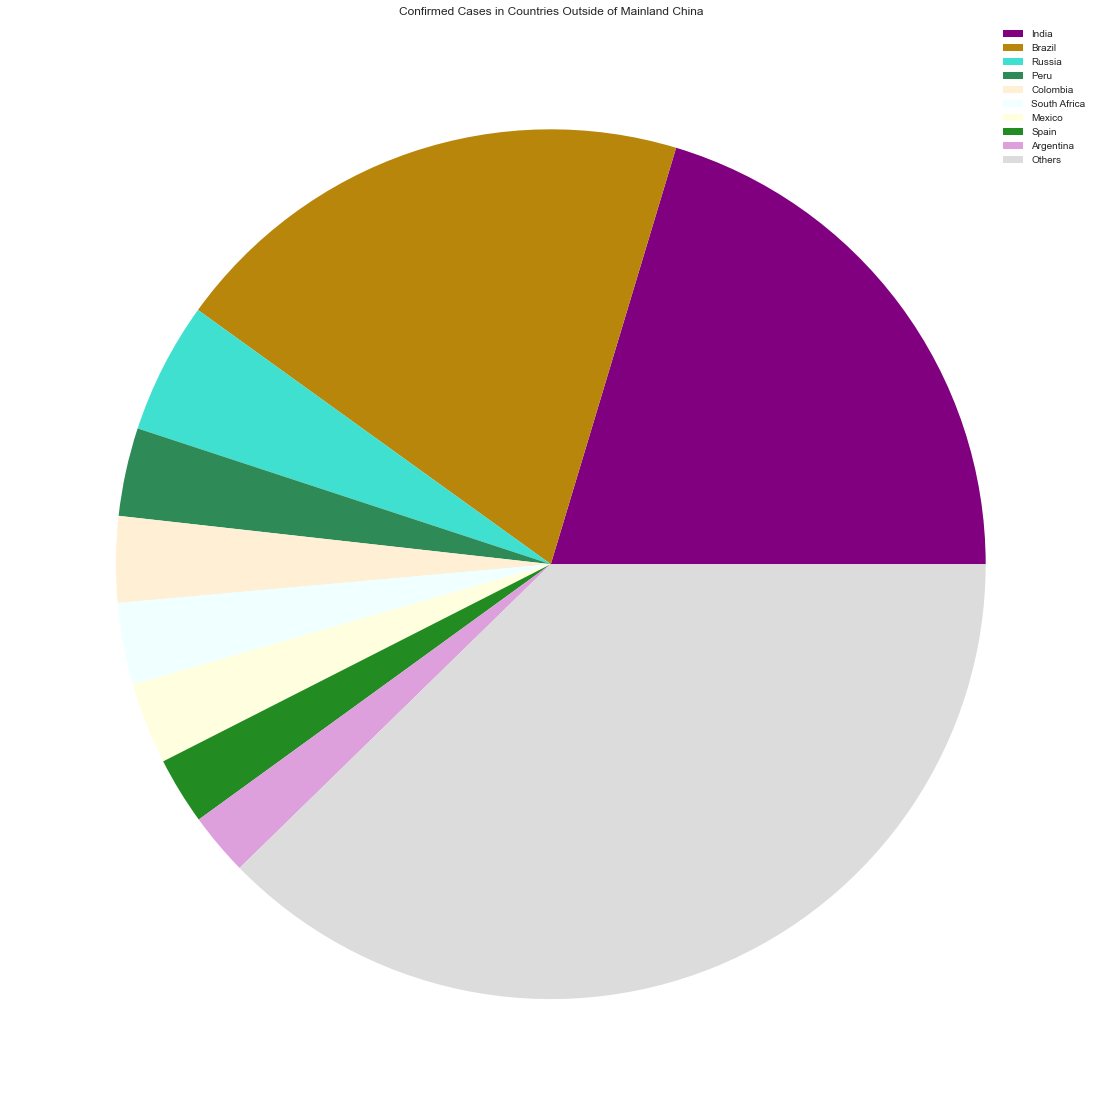

In [39]:
c = random.choices(list(mcolors.CSS4_COLORS.values()), k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Confirmed Cases in Countries Outside of Mainland China')
plt.pie(visual_confirmed_cases[1:], colors=c)
plt.legend(visual_unique_countries[1:], loc='best')
plt.show()

In [40]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since, world_cases,
                                                    test_size=0.30)

In [41]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forecast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:', mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 2664562.3811211404
MSE: 9196264197842.885


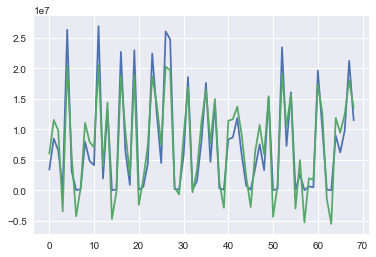

In [42]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)

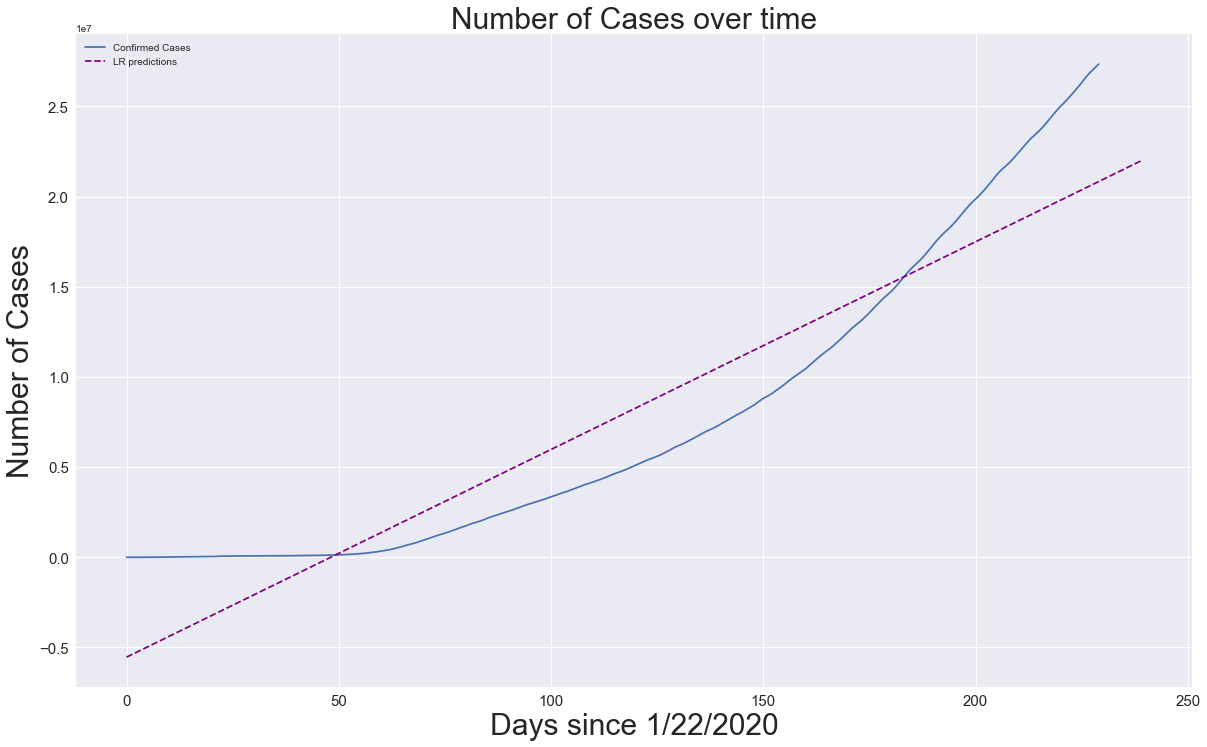

In [43]:
plt.figure(figsize = (20,12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forecast, linear_pred, linestyle='dashed', color='purple')
plt.title('Number of Cases over time', size=30)
plt.xlabel('Days since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size = 30)
plt.legend(['Confirmed Cases', 'LR predictions'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

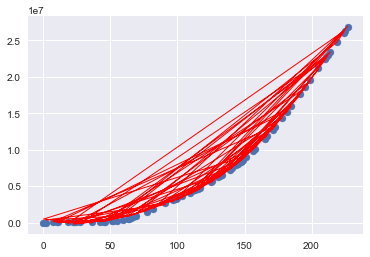

In [44]:
from sklearn.preprocessing import PolynomialFeatures
poli_reg = PolynomialFeatures(degree = 5)
#Se transforma las características existentes en características de mayor grado
X_train_poli = poli_reg.fit_transform(X_train_confirmed)
X_test_poli = poli_reg.fit_transform(X_test_confirmed)
#Defino el algoritmo a utilizar
pr = LinearRegression()
#Entreno el modelo
pr.fit(X_train_poli, y_train_confirmed)
#Realizo una predicción
Y_pred_pr = pr.predict(X_test_poli)

pred = pr.predict(poli_reg.fit_transform(future_forecast))
#Graficamos los datos junto con el modelo
plt.scatter(X_test_confirmed, y_test_confirmed)
plt.plot(X_test_confirmed, Y_pred_pr, color='red', linewidth=1)
plt.show()

In [45]:
print('MAE:', mean_absolute_error(Y_pred_pr, y_test_confirmed))
print('MSE:', mean_squared_error(Y_pred_pr, y_test_confirmed))

MAE: 164877.93910587323
MSE: 38714175087.27905


#### El error es demasiado grande porque es el acumulado desde los primeros días hasta el último

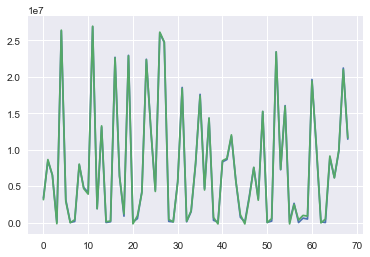

In [46]:
plt.plot(y_test_confirmed)
plt.plot(Y_pred_pr)

In [47]:
print('Linear regression future predictions:')
print(pred[-10:])

Linear regression future predictions:
[[27750680.98849235]
 [28016498.20170484]
 [28281072.89101861]
 [28544289.69492166]
 [28806030.89404987]
 [29066176.39118348]
 [29324603.69124334]
 [29581187.88128774]
 [29835801.61050873]
 [30088315.07022838]]


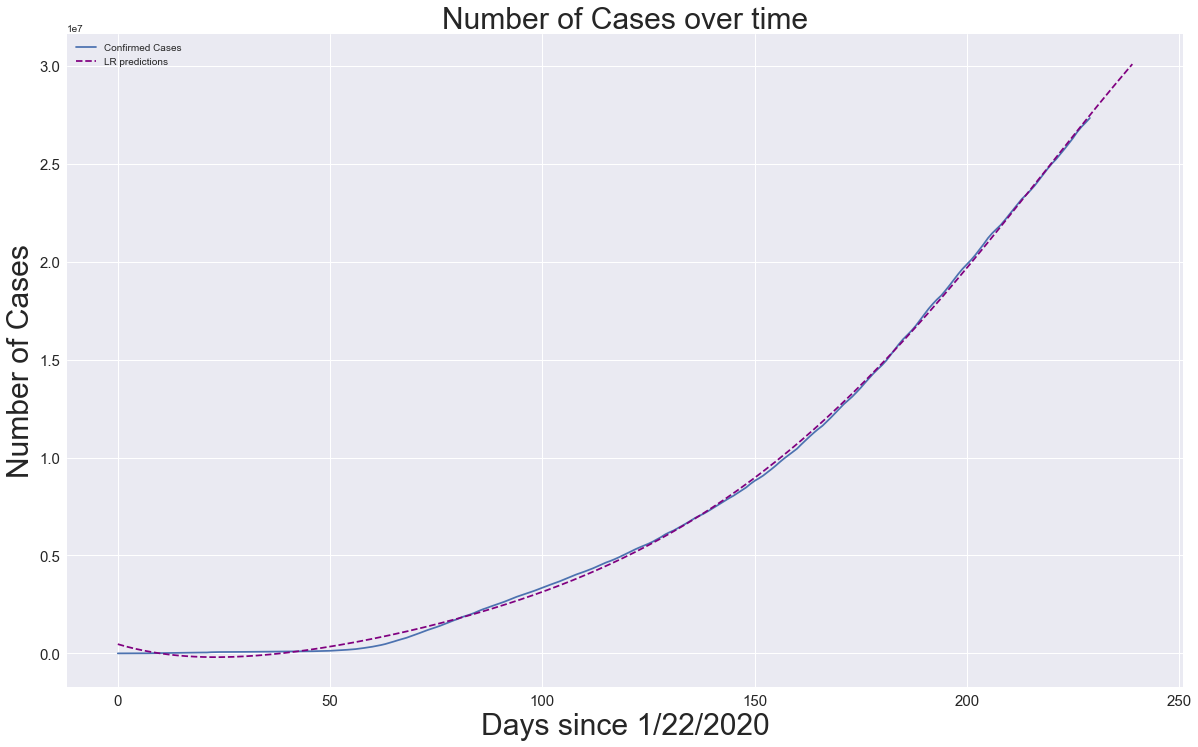

In [49]:
plt.figure(figsize = (20,12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forecast, pred, linestyle='dashed', color='purple')
plt.title('Number of Cases over time', size=30)
plt.xlabel('Days since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size = 30)
plt.legend(['Confirmed Cases', 'LR predictions'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [51]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since, total_deaths,
                                                    test_size=0.30)

In [52]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forecast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:', mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 39623.96972967073
MSE: 2449281898.775601


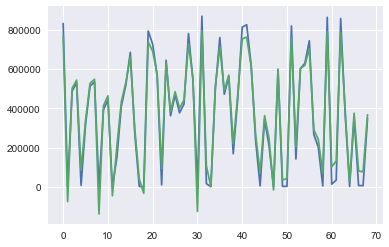

In [53]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)

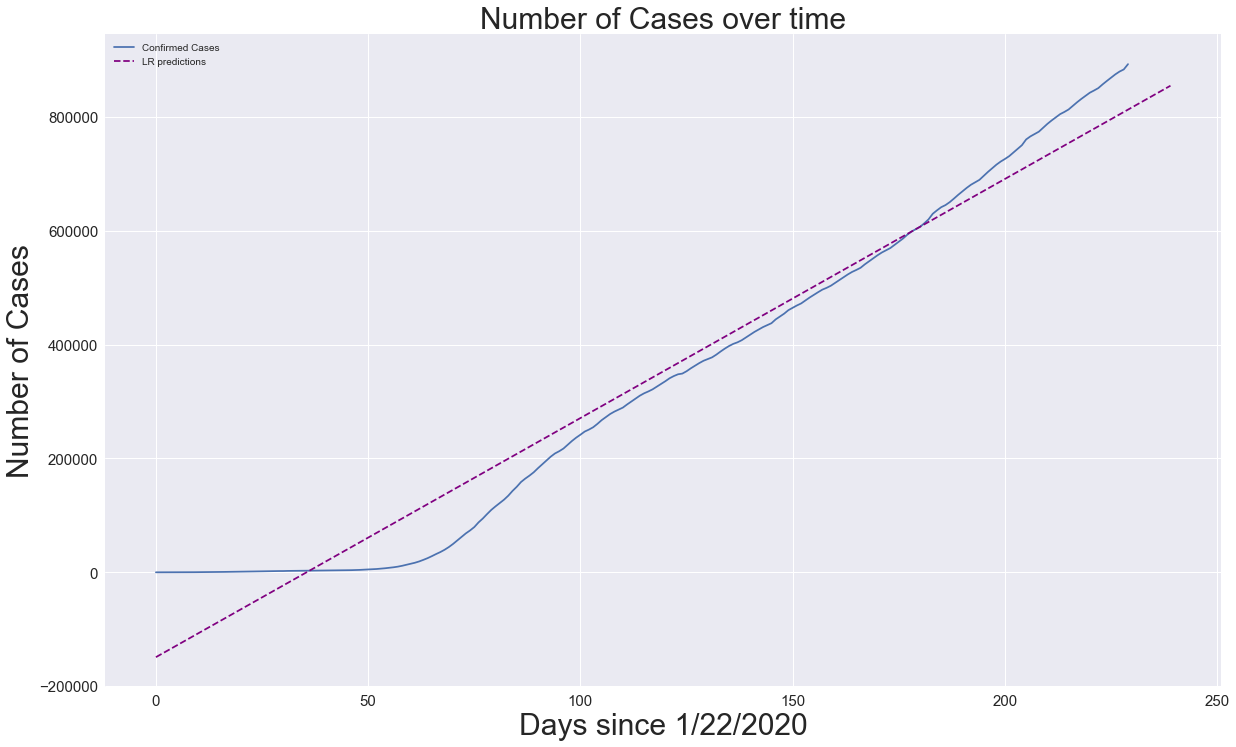

In [54]:
plt.figure(figsize = (20,12))
plt.plot(adjusted_dates, total_deaths)
plt.plot(future_forecast, linear_pred, linestyle='dashed', color='purple')
plt.title('Number of Cases over time', size=30)
plt.xlabel('Days since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size = 30)
plt.legend(['Confirmed Cases', 'LR predictions'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

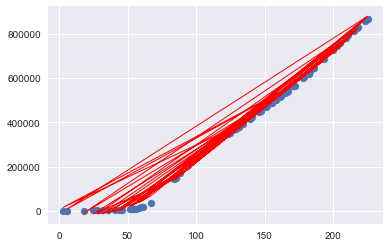

In [55]:
from sklearn.preprocessing import PolynomialFeatures
poli_reg = PolynomialFeatures(degree = 5)
#Se transforma las características existentes en características de mayor grado
X_train_poli = poli_reg.fit_transform(X_train_confirmed)
X_test_poli = poli_reg.fit_transform(X_test_confirmed)
#Defino el algoritmo a utilizar
pr = LinearRegression()
#Entreno el modelo
pr.fit(X_train_poli, y_train_confirmed)
#Realizo una predicción
Y_pred_pr = pr.predict(X_test_poli)

pred = pr.predict(poli_reg.fit_transform(future_forecast))
#Graficamos los datos junto con el modelo
plt.scatter(X_test_confirmed, y_test_confirmed)
plt.plot(X_test_confirmed, Y_pred_pr, color='red', linewidth=1)
plt.show()

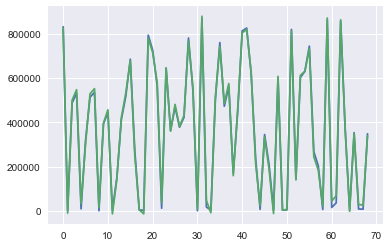

In [56]:
plt.plot(y_test_confirmed)
plt.plot(Y_pred_pr)

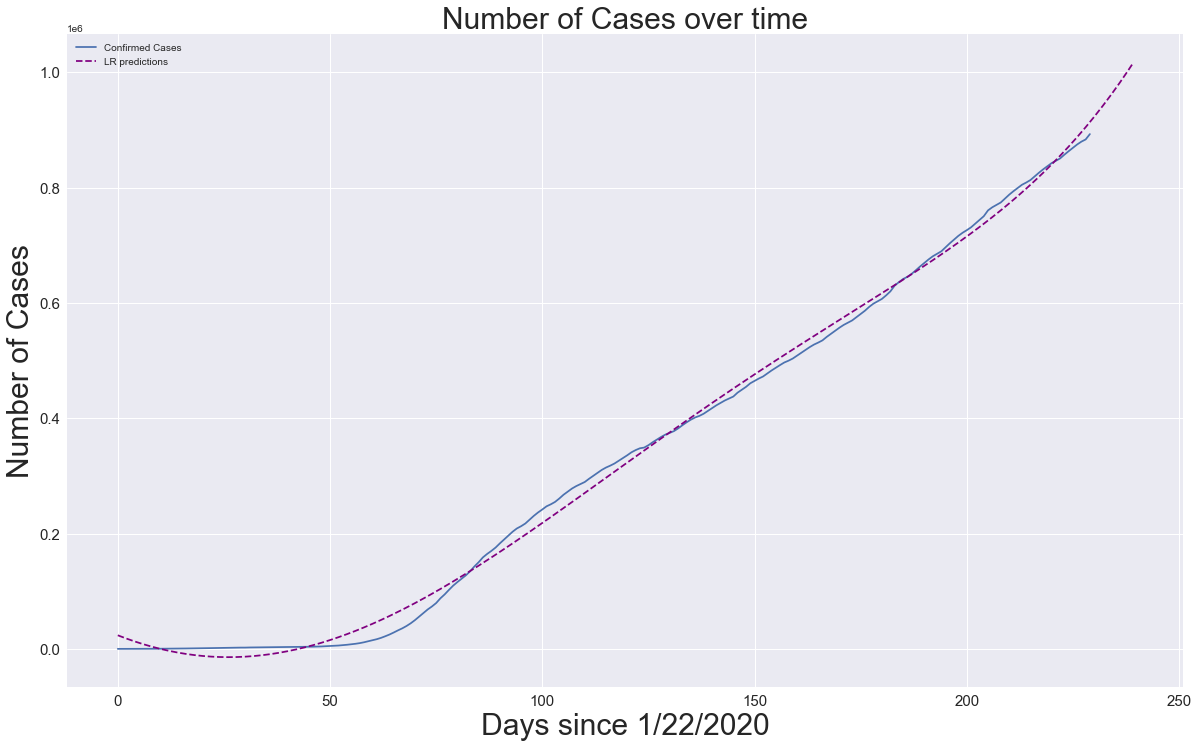

In [57]:
plt.figure(figsize = (20,12))
plt.plot(adjusted_dates, total_deaths)
plt.plot(future_forecast, pred, linestyle='dashed', color='purple')
plt.title('Number of Cases over time', size=30)
plt.xlabel('Days since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size = 30)
plt.legend(['Confirmed Cases', 'LR predictions'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### Con el fin de entender un poquitín mejor el estado de la pandemia por el COVID19 en México, realizaremos un pronóstico de los nuevos casos por día.

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline

In [76]:
#Html paths for csv files from John Hopkins - Confirmed / Death cases
confirmedPath = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deathsPath = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [116]:
confirmed_cases = pd.read_csv(confirmedPath, header=0, index_col=0, parse_dates=True, squeeze=True)
death_cases = pd.read_csv(deathsPath, header=0, index_col=0, parse_dates=True, squeeze=True)
confirmed_cases = confirmed_cases.reset_index()
death_cases = death_cases.reset_index()

In [117]:
cols = confirmed_cases.keys()
cols

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '8/29/20', '8/30/20', '8/31/20', '9/1/20', '9/2/20', '9/3/20', '9/4/20',
       '9/5/20', '9/6/20', '9/7/20'],
      dtype='object', length=234)

In [118]:
mexico = confirmed_cases[confirmed_cases["Country/Region"] == "Mexico"]
mexico

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20
177,NaN,Mexico,23.6345,-102.5528,0,0,0,0,0,0,...,591712,595841,599560,606036,610957,616894,623090,629409,634023,637509


In [120]:
confirmed = mexico.loc[:, cols[4]:cols[-1]]
deaths = death_cases.loc[:, cols[4]:cols[-1]]
confirmed

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20
177,0,0,0,0,0,0,0,0,0,0,...,591712,595841,599560,606036,610957,616894,623090,629409,634023,637509


In [115]:
dates = confirmed.keys()
world_cases = []
total_deaths = []
mortality_rate = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)

<ipython-input-115-3c7a5eea54f8>:11: RuntimeWarning: divide by zero encountered in longlong_scalars
  mortality_rate.append(death_sum/confirmed_sum)


In [102]:
days_since = np.array([i for i in range(len(dates))]).reshape(-1,1)
world_cases = np.array(world_cases).reshape(-1,1)
total_deaths = np.array(total_deaths).reshape(-1,1)

In [103]:
days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1)
adjusted_dates = future_forecast[:-10]

In [104]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [105]:
latest_confirmed = confirmed_cases[dates[-1]]
latest_deaths = death_cases[dates[-1]]

In [106]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since, world_cases,
                                                    test_size=0.30)

In [107]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forecast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:', mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 2440912.427415575
MSE: 7730080063211.459


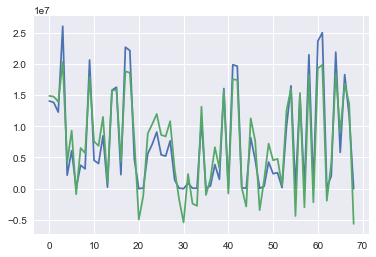

In [108]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)

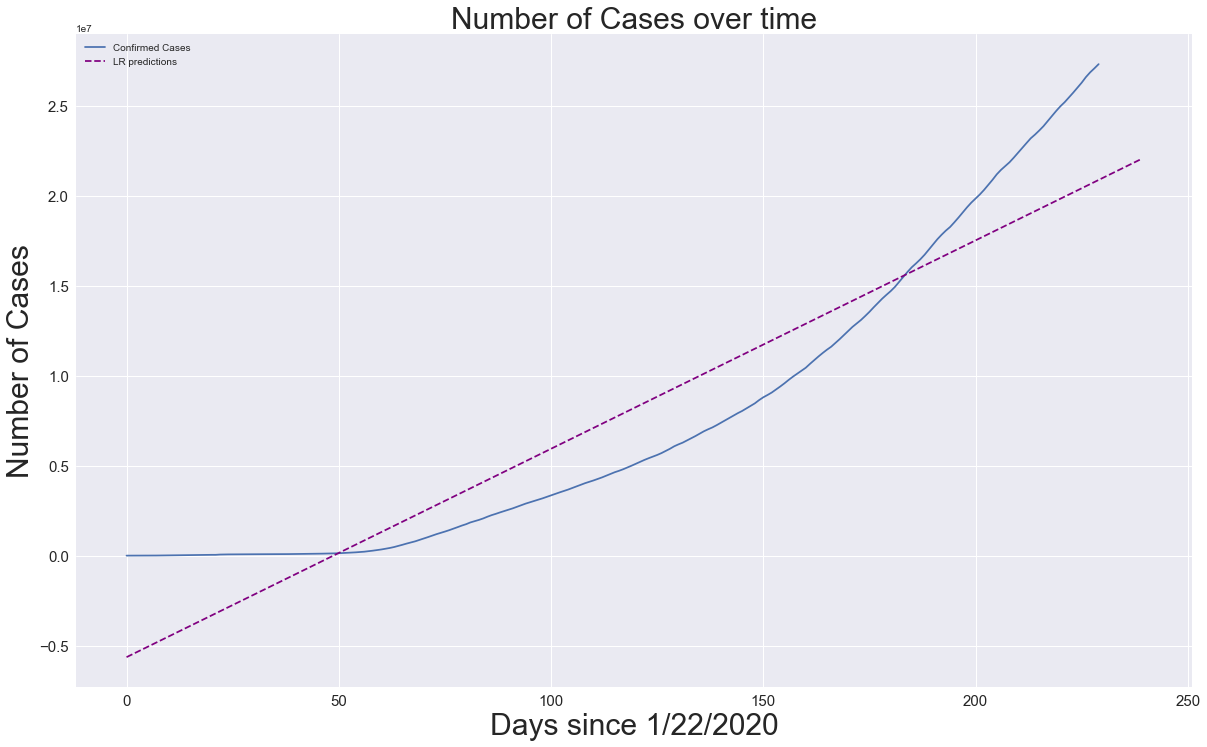

In [109]:
plt.figure(figsize = (20,12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forecast, linear_pred, linestyle='dashed', color='purple')
plt.title('Number of Cases over time', size=30)
plt.xlabel('Days since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size = 30)
plt.legend(['Confirmed Cases', 'LR predictions'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()